In [58]:
PATH='image_classifier/'
sz=224

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import os
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [5]:
os.listdir('image_classifier/valid')

['cricket', 'baseball']

In [7]:
files=os.listdir('image_classifier/valid/cricket')
files

['Rishabh-Pant-of-the-Delhi-Daredevils-avoids-a-rising-delivery-from-Tymal-Mills-of-the-Royal-Challengers-Bangalore.jpg',
 'cricket-4-grant_1970792i.jpg',
 'images.jpeg']

In [56]:
import matplotlib.pyplot as plt
img=plt.imread(f'image_classifier/valid/cricket/{files[2]}')

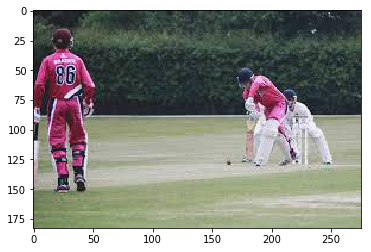

In [57]:
plt.imshow(img)

In [46]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
arch=resnet34
data=ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch,sz))
learn=ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(0.01,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.717855   0.578584   0.666667  



[array([ 0.57858]), 0.66666668653488159]

In [30]:
data.val_y

array([0, 0, 0, 1, 1, 1])

In [31]:
data.classes

['baseball', 'cricket']

In [32]:
log_preds=learn.predict()
log_preds.shape

(6, 2)

In [33]:
log_preds[:]

array([[-0.66674, -0.72027],
       [-0.16708, -1.87167],
       [-0.52488, -0.89557],
       [-0.48176, -0.96154],
       [-0.65954, -0.72793],
       [-1.42263, -0.27586]], dtype=float32)

In [59]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [72]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=True)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [73]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [74]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [47]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.7021     0.58522    0.666667  



Correctly classified


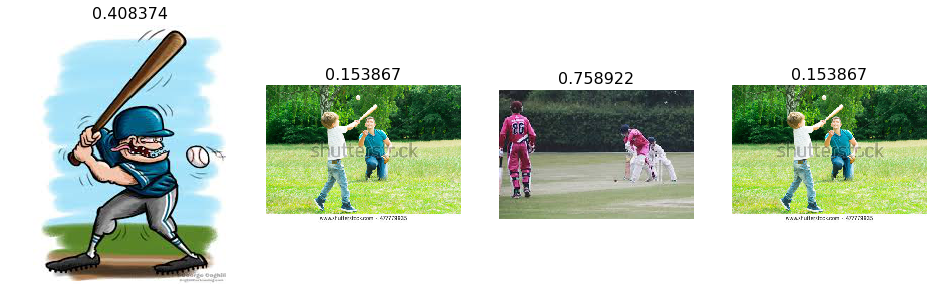

In [75]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


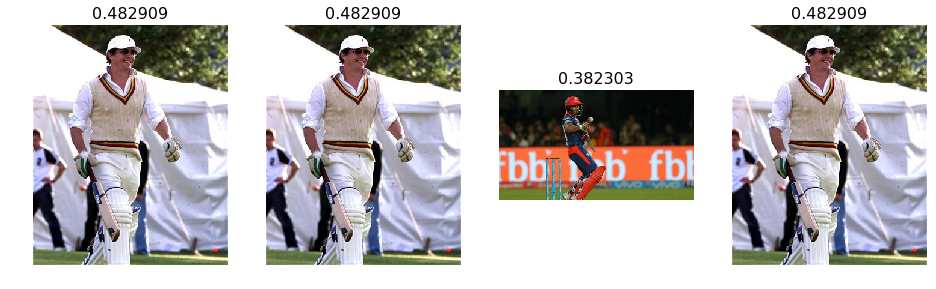

In [76]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [77]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct baseball


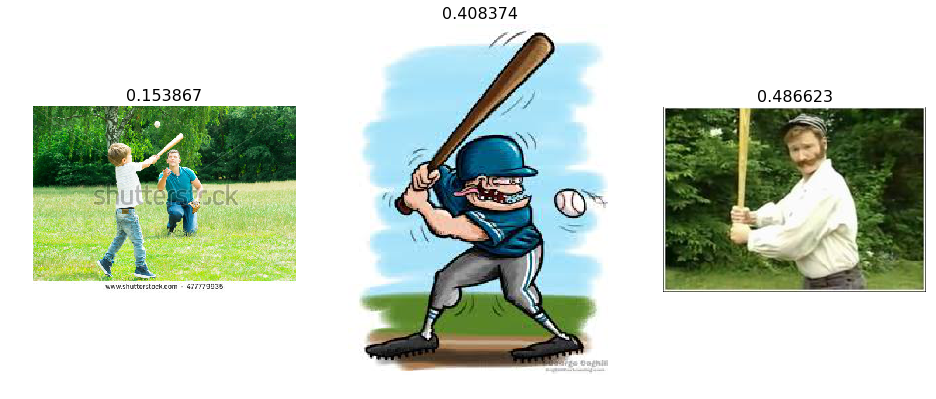

In [78]:
plot_val_with_title(most_by_correct(0, True), "Most correct baseball")

In [79]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect baseball")

Most incorrect baseball
Not Found.


Most incorrect cricket


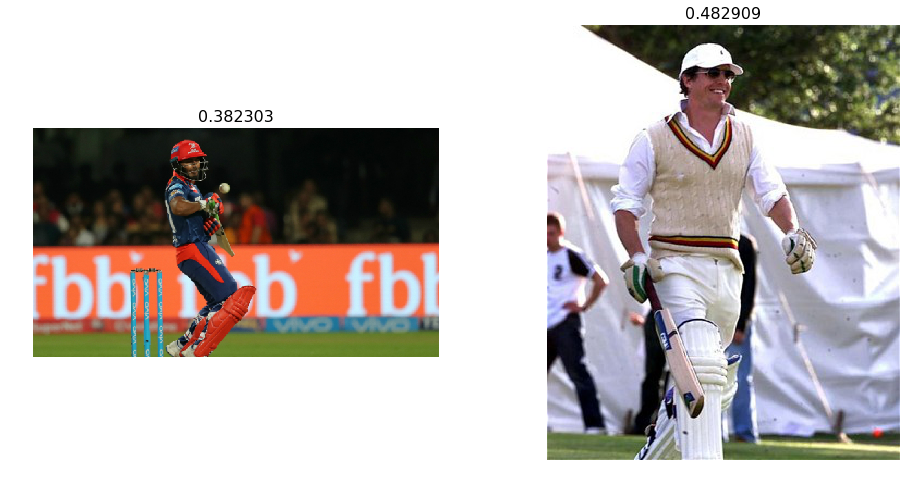

In [69]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect cricket")

Most uncertain predictions


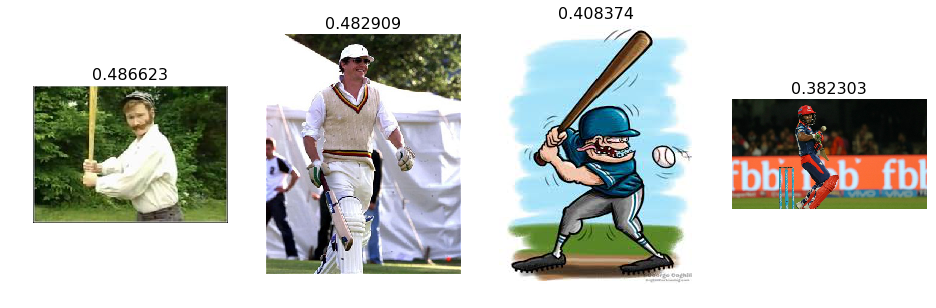

In [70]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")